In [23]:
import pennylane as qml
from matplotlib import pyplot as plt
import numpy as np
from numpy import array
import scipy
from scipy.optimize import minimize
import itertools

#Qiskit
from qiskit import *
from qiskit.circuit import Parameter
import qiskit.quantum_info as qi
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

import sys
sys.path.append('../')

In [2]:
# Before running this code, you need to load your account using the API token available
# in your welcome page of the IBM Quantum website (https://quantum-computing.ibm.com/). 
# In the first time, you will need to use the command IBMQ.save_account(your_token) 
# to save your account.

# IBMQ.save_account(your_token)
IBMQ.load_account()

# Fill the information (hub, group and project) about your provider
hub = ''
group = ''
project = ''

provider = IBMQ.get_provider(hub=hub,
                             group=group,
                             project=project)

backend = provider.get_backend('ibm_lagos')
back_str = str(backend)
print("Backend:", backend)

Backend: ibm_lagos


In [3]:
# Get noise model from backend
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# Define layout for transpilation 
initial_layout = [0, 1, 3, 5]

In [4]:
depth = 1 #Ansatz depth
n_rotations = 3 #Number of rotations parameters in each layer of the ansatz
nr_qubits = 1 #Number of qubits

def device(wire, real_device=False):
    
    if real_device == True:
        dev = qml.device("qiskit.ibmq",
                        wires=nr_qubits,
                        backend=back_str,
                        shots=8192,
                        hub=hub,
                        group=group,
                        project=project
                        )
        dev.set_transpile_args(initial_layout=[wire])

    
    else:
        dev = qml.device("qiskit.aer",
                        wires=nr_qubits,
                        noise_model=noise_model,
                        shots=8192,
                        )   
    
    return dev

In [5]:
#Devices' layout
devc = device(initial_layout[0], real_device=False)
devh = device(initial_layout[-1], real_device=False)

### System Parameters

In [6]:
Iqml = np.identity(2)
Zqml = np.array([[1,0],[0,-1]])

#Temperature
T1 = 0.4
T2 = 0.8

beta_c = 1/T1 # 1/T1
beta_h = 1/T2 # 1/T2

# Parameters
w1 = 0.75
w2 = 1
wc = w1
wh = w2

gch = 0.8
g12 = 0.8

# Strokes durations
tq = 1
tw = 1

# Number of Measurement
N = 8

#Trotter steps
M = 1

H1 = (w1 / 2) * Zqml
H2 = (w2 / 2) * Zqml

Hc = (wc / 2) * Zqml
Hh = (wh / 2) * Zqml

Training...
Cost at Step 0: -1.0387098728601663
Cost at Step 5: -0.5620396673940697
Cost at Step 10: -1.0717893925002713
Cost at Step 15: -1.0648066595319958
Finished after 20 steps.


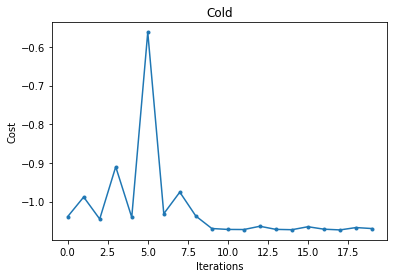

Training...
Cost at Step 0: -0.8145972240019621
Cost at Step 5: -0.7291894453299816
Cost at Step 10: -0.8624241973287384
Cost at Step 15: -0.8732026924710077
Finished after 20 steps.


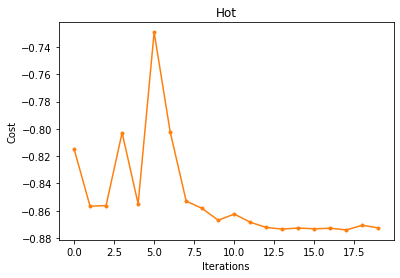

In [7]:
%run ../vqt.ipynb

In [8]:
# Parameters
phis = ['phi'+str(n) for n in range(depth*3)] #3 rotations
phi = [Parameter(ang) for ang in phis]

In [9]:
qc_barrier = QuantumCircuit(2)

qc_barrier.barrier()

qc_barrier = qc_barrier.reverse_bits()

In [10]:
def qc_vqt(wire):
    qc = QuantumCircuit(2)
    m=0
    for i in range(depth):
        #RZ-SX-RZ-SX-RZ
        qc.rz(phi[m],wire)
        qc.sx(wire)
        qc.rz(phi[m+1],wire)
        qc.sx(wire)
        qc.rz(phi[m+2],wire)
        m=m+3
    
    qc = qc.reverse_bits()
    return qc

def qc_x(wire):
    qc = QuantumCircuit(2)
    qc.x(wire)
    qc = qc.reverse_bits()
    return qc

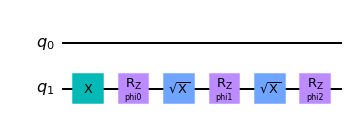

In [11]:
qc_c1 = qc_vqt(0)
#qc_c2 = qc_x(0).compose(qc_barrier).compose(qc_c1)
qc_c2 = qc_x(0).compose(qc_c1)
qc_c2.draw('mpl')

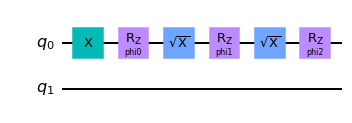

In [12]:
qc_h1 = qc_vqt(1)
#qc_h1 = qc_x(1).compose(qc_barrier).compose(qc_h1)
qc_h2 = qc_x(1).compose(qc_h1)
qc_h2.draw('mpl')

In [13]:
from VQT import prob_dist

# Prepares the optimal parameters and distribution for Hc
dist_params_c = out_params_c[0]
unitary_params_c = out_params_c[1:]
distribution_c = prob_dist(dist_params_c)

# Prepares the optimal parameters and distribution for Hh
dist_params_h = out_params_h[0]
unitary_params_h = out_params_h[1:]
distribution_h = prob_dist(dist_params_h)

# Parameters Bindings
phi_dict_c = dict(zip(phi, unitary_params_c))
phi_dict_h = dict(zip(phi, unitary_params_h))

# Bind Parameters to circuits
qc_c1_bind = qc_c1.bind_parameters(phi_dict_c)
qc_c2_bind = qc_c2.bind_parameters(phi_dict_c)
qc_h1_bind = qc_h1.bind_parameters(phi_dict_h)
qc_h2_bind = qc_h2.bind_parameters(phi_dict_h)

thermal_circs = [qc_c1_bind.compose(qc_h1_bind),
                 qc_h2_bind.compose(qc_c1_bind),
                 qc_c2_bind.compose(qc_h1_bind),
                 qc_c2_bind.compose(qc_h2_bind)]

In [14]:
# Generate the state tomography circuits.
qst = []
for circuit in thermal_circs:
    qst.append(state_tomography_circuits(circuit, [0, 1]))
    
#qst = np.reshape(qst,(1,36))
#qst = list(qst[0])
#print(qst)

In [15]:
#Backend
backend_sim = Aer.get_backend('qasm_simulator')
shots = 8192 #Number of shots

results = []
for i in range(len(thermal_circs)):
    job = execute(qst[i],
                  backend = backend_sim,
                  noise_model=noise_model,
                  coupling_map=coupling_map,
                  basis_gates=basis_gates,
                  shots = shots)
    job_monitor(job, interval=2)
    results.append(job.result())

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [16]:
rhos = []
for i in range(len(thermal_circs)):
    # Fit result
    tomo_fitter = StateTomographyFitter(results[i], qst[i])
    rhos.append(tomo_fitter.fit(method='lstsq'))
    #tomo_fitter.fit(method='lstsq')

In [17]:
# Initializes the density matrix

final_density_matrix = np.zeros((2 **2, 2 ** 2))

combos = itertools.product([0, 1], repeat=2)
s = [list(c) for c in combos]

dist_final = prob_dist([dist_params_c,dist_params_h])

for i, sample in zip(s,rhos):
    dist_aux = 1
    for j in range(0, len(i)):
        dist_aux = dist_final[j][i[j]]*dist_aux
    final_density_matrix = np.add(final_density_matrix, dist_aux*sample)

In [18]:
print(final_density_matrix)

[[3.98493960e-02+0.00000000e+00j 2.87761703e-04+2.34552907e-04j
  8.70524274e-04-2.79877827e-03j 7.72744264e-04-4.27411943e-05j]
 [2.87761703e-04-2.34552907e-04j 1.24940047e-01+0.00000000e+00j
  1.55871208e-03-1.60328543e-03j 1.51048599e-03-5.62025804e-03j]
 [8.70524274e-04+2.79877827e-03j 1.55871208e-03+1.60328543e-03j
  2.01383875e-01+0.00000000e+00j 7.75392741e-04-2.16078603e-03j]
 [7.72744264e-04+4.27411943e-05j 1.51048599e-03+5.62025804e-03j
  7.75392741e-04+2.16078603e-03j 6.33826682e-01+0.00000000e+00j]]


In [19]:
from VQT import create_target

from qiskit import *
import qiskit.quantum_info as qi

target_rho_c = create_target(beta_c, Hc)
target_rho_h = create_target(beta_h, Hh)

target_final = np.kron(target_rho_c,target_rho_h)

print(target_final)

[[0.02961115 0.         0.         0.        ]
 [0.         0.10335309 0.         0.        ]
 [0.         0.         0.19308898 0.        ]
 [0.         0.         0.         0.67394678]]


In [20]:
print("Fidelity: " + str(qi.state_fidelity(target_final, final_density_matrix)))

Fidelity: 0.9974226951113456
